In [1]:
import requests
from io import BytesIO
from PIL import Image

from torchvision import transforms
from transformers import OFATokenizer, OFAModel

from semshap.masking import generate_segmentation_masks
from semshap.plot import plot_masks

import torch.nn as nn
from semshap.explainers import BaseExplainer
from semshap.plot import barh, heatmap
import matplotlib.pyplot as plt

import torch

In [2]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

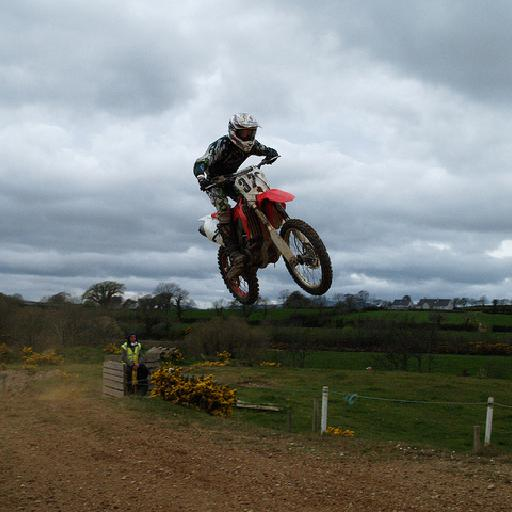

In [3]:
img_url ="https://marhamilresearch4.blob.core.windows.net/stego-public/sample_images/moto1.jpg"
response = requests.get(img_url)
img = Image.open(BytesIO(response.content))
img

In [6]:
ckpt_dir = "OFA-tiny"
device = "cuda" if torch.cuda.is_available() else "cpu"

In [7]:
# load the model
model = OFAModel.from_pretrained(ckpt_dir, use_cache=False).to(device)
tokenizer = OFATokenizer.from_pretrained(ckpt_dir)

/home/michele/PycharmProjects/vl-shap/semshap/venv2/lib/python3.10/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3526.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


OFA-tiny
<super: <class 'OFATokenizer'>, <OFATokenizer object>>


## Generate the semantic masks with CLIPSEG

In [17]:
img.size

(512, 512)

In [18]:
prompts = ['person', 'motorcycle', 'dirt', 'sky']
out =  generate_segmentation_masks(img, prompts, img_size=img.size)

In [19]:
masks = out['masks']

(<Figure size 640x480 with 6 Axes>,
 array([[<Axes: title={'center': '0'}>, <Axes: title={'center': '1'}>,
         <Axes: title={'center': '2'}>],
        [<Axes: title={'center': '3'}>, <Axes: title={'center': '4'}>,
         <Axes: >]], dtype=object))

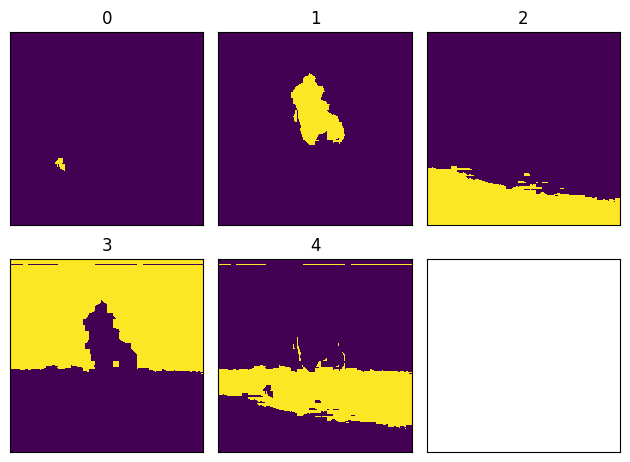

In [20]:
plot_masks(masks)

## Run the explainer

In [21]:
class ModelWrapper(nn.Module):
    def __init__(self, model, tokenizer, question, resolution, device="cpu"):
        super().__init__()
        
        self.resolution=resolution
        self.num_beams = 5
        self.no_repeat_ngram_size = 3
        self.model = model
        self.tokenizer = tokenizer
        self.device = device
        self.patch_resize_transform = transforms.Compose([
                                                            lambda image: image.convert("RGB"),
                                                            transforms.Resize(self.resolution, interpolation=Image.BICUBIC),
                                                            transforms.ToTensor(),
                                                            transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
                                                        ])
        
        self.inputs = tokenizer([question], return_tensors="pt").input_ids.to(self.device)
        
    

    def forward(self, img):
        # put here all to code to generate a caption from an image
        
        patch_img = self.patch_resize_transform(img).unsqueeze(0).to(self.device)
        out_ids = model.generate(self.inputs, patch_images=patch_img, num_beams=self.num_beams, 
                                 no_repeat_ngram_size=self.no_repeat_ngram_size)
        
        return tokenizer.batch_decode(out_ids, skip_special_tokens=True)[0]

In [22]:
question = "What is the subject doing?"
model_wrapper = ModelWrapper(model, tokenizer, question, resolution=img.size, device=device)

In [23]:
model_wrapper(img)

' riding a dirt bike'

In [24]:
explainer = BaseExplainer(model_wrapper, device=device)

In [25]:
shap, base = explainer.explain(img, masks, k=-1)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:01<00:00, 21.90it/s]


Text(0.5, 1.0, 'Brute force KernelSHAP')

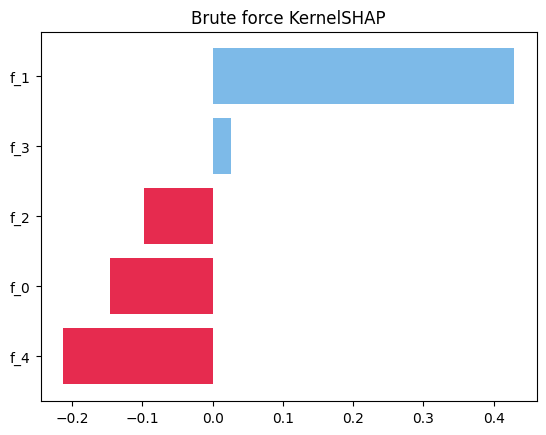

In [26]:
labels = [ f"f_{i}" for i in range(shap.shape[0]) ]
barh(labels, shap)

plt.title("Brute force KernelSHAP")

(<Figure size 640x480 with 2 Axes>,
 <Axes: >,
 <matplotlib.colorbar.Colorbar at 0x7fa904a5ba60>)

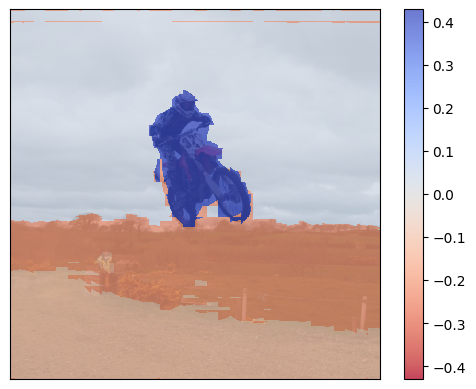

In [27]:
heatmap(img, masks, shap, alpha=0.75, vmin=-max(abs(shap)), vmax=max(abs(shap)))